<a href="https://colab.research.google.com/github/sinheechan/ML/blob/main/%5BDataset%5D_%ED%94%BC%EB%A7%88_%EC%9D%B8%EB%94%94%EC%96%B8_%EB%8B%B9%EB%87%A8%EB%B3%91_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Dataset] Pima Indians Diabetes

- 이 데이터 세트는 국립 당뇨병, 소화기 및 신장 질환 연구소에서 가져온 것으로
이 데이터의 목적은 데이터세트에 포함된 특정 진단 측정값을 기반으로 환자에게 당뇨병이 있는지 여부를 진단적으로 예측하는 것입니다.
- 더 큰 데이터베이스에서 이러한 인스턴스를 선택하는 데 몇 가지 제약이 적용되었으며 특히 이곳의 환자들은 모두 피마 인디언 혈통의 21세 이상의 여성입니다.
- 본 분석에서는 데이터 세트에 있는 환자의 당뇨병 여부를 정확하게 예측하는 기계 학습 모델을 구축하는 것을 목표로 합니다.

## 1. 초기 설정

### 1.1 라이브러리 Import

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# numpy 추가 설정
np.random.seed(2024)
np.set_printoptions(precision = 4, suppress = True)

# pandas 추가 설정
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 80

# matplotlib 추가 설정
plt.rc("figure", figsize = (8, 4))
colors = sns.color_palette('husl')

### 1.2 데이터 불러오기

In [75]:
diabetes_data = pd.read_csv('/content/diabetes.csv')

## 2. EDA

In [76]:
diabetes_data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [77]:
print(diabetes_data['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


In [78]:
diabetes_data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- data의 Outcome은 당뇨병 유무를 나타내며 0은 음성, 1은 양성을 나타낸다
- Null 값은 존재하지 않으며, 모두 숫자형 데이터이다.

## 3. 머신러닝

- 데이터셋에서는 분류를 위한 알고리즘인 로지스틱 회귀를 이용하여 예측 모델을 만든다.
- 그리고 그 이전에 분류모델의 성능을 평가하는 지표를 함수 설정하고 평가지표 출력까지 세팅한다.

In [91]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix( y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

- 임계값에 따른 Precision-Recall 곡선을 그리는 함수

In [80]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # x축을 threshold(한계점), y축을 precision(정밀도), Recall(재현율)로 그래프 그리기
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

- 피처 데이터 세트 X와 레이블 데이터 세트 y를 추출한다.
  - X : 'Outcome' 컬럼을 제외한 나머지 피처
  - y : 'Outcome' 컬럼 값

In [92]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

- 로지스틱 회귀로 학습, 예측 및 평가 수행한다.

In [93]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train , y_train)

pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[88 12]
 [22 32]]
정확도: 0.7792, 정밀도: 0.7273, 재현율: 0.5926,    F1: 0.6531, AUC:0.8437


- 예측된 확률을 사용하여 임계값별로 정밀도-재현율 시각화한다.

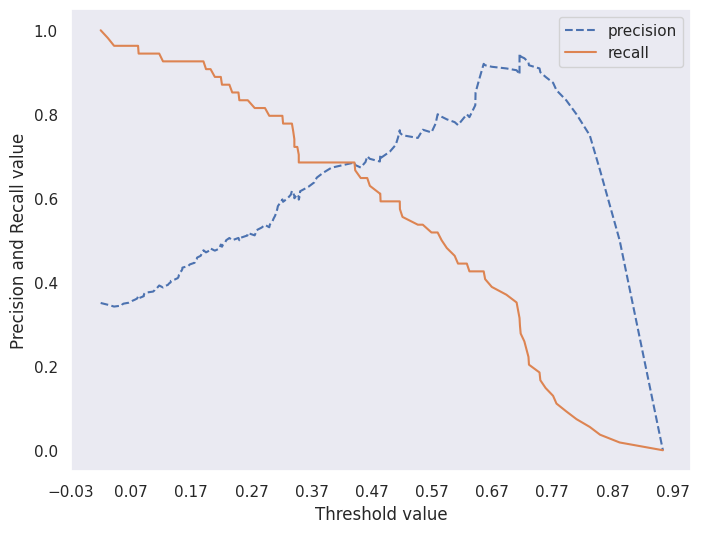

In [82]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [83]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 위의 결과를 보면 최소값이 0으로 되어 있는 데이터들이 다수 존재하는 것을 볼 수 있다.
- Glocose(당 수치), BloodPressure(혈압), SkinThickness(피하지망), 인슐린(Insulin), BMI(체질량지수) 같은 값이 실제로 0일 수는 없으므로 더 상세한 데이터 확인이 필요하다.

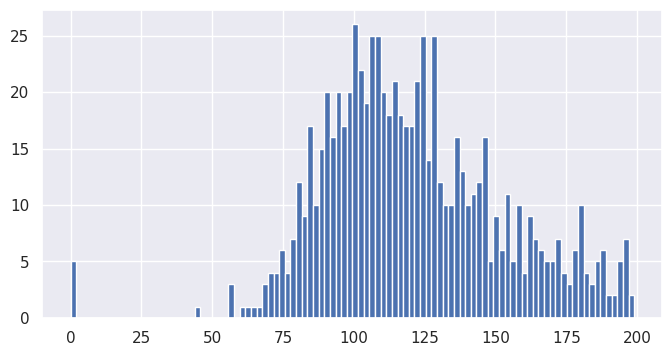

In [84]:
plt.hist(diabetes_data['Glucose'], bins=100)

plt.show()

In [85]:
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI'] # 포도당, 혈압, 피부두께, 인슐린, BMI

total_count = diabetes_data['Glucose'].count()
print(total_count)

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()

    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

768
Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


- 위의 값들이 실제로 0일 가능성은 희박해보이므로 0 값을 평균으로 대체한다.
- SkinThickness와 Insulin의 경우 0 값의 비율이 29.56%, 48.70%로 상당히 높아 변경 영향도가 상대적으로 더 클 것으로 예상된다.

In [86]:
mean_zero_features = diabetes_data[zero_features].mean()

diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

- 로지스틱회귀의 경우, 숫자데이터에 스케일링을 적용하면 성능이 더 개선됨으로 StandardScaler를 적용한다.

In [87]:
# 데이터 셋에 StandardScaler를 적용하여 변환하기
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

# train/test 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


- 0 값을 평균으로 처리한 후 스케일링을 하고 나니 앞선 예측보다는 소폭 개선되었다.
- 주어진 임곗값(threshold)에 대해 예측 확률(pred_proba_c1)을 기준으로 이진 분류를 수행하고, 그 결과를 평가한다.

In [88]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):

    # thresholds 리스트 객체내의 값을 차례로 이터레이션 하면서 평가 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [89]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


- 위와 같이 정확도, 정밀도, 재현율, F1, AUC 등의 평가지표를 보고 적절히 판단하여 임계값을 선택한 후, 예측을 수행한다.
- 임곗값을 0.48로 설정한 이진화 작업을 수행하고, 이진화된 예측 결과와 원래의 예측 확률을 사용하여 성능을 평가한다.

In [90]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1))

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
